## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l2

def build_mlp(input_shape, output_units = 10, num_neurons = [256, 128, 64]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0: 
            x = keras.layers.Dense(units = n_units, activation = 'relu')(input_layer)
        else:
            x = keras.layers.Dense(units = n_units, activation = 'relu')(x)
    
    out = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    
    return model

In [6]:
def build_mlp2(input_shape, output_units = 10, num_neurons = [256, 128, 64], l2_ratio = 1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0: 
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    
    return model

In [7]:
def build_mlp3(input_shape, output_units = 10, num_neurons = [256, 128, 64], l2_ratio = 1e-4, drop_ratio = 0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0: 
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    
    return model

In [8]:
def build_mlp4(input_shape, output_units = 10, num_neurons = [256, 128, 64], l2_ratio = 1e-4, drop_ratio = 0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0: 
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units = n_units, activation = 'relu', kernel_regularizer = l2(l2_ratio))(x)
            x = Dropout(drop_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    
    return model

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
functions = [build_mlp, build_mlp2, build_mlp3, build_mlp4]

In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for fun in functions: 
    keras.backend.clear_session()
    print('Experiment with %s' % (str(fun)))
    model = fun(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizer)
    model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_test, y_test), shuffle = True)
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']
    
    exp_label = 'exp-fun-%s' %(str(fun))
    results[exp_label] = {'train-loss': train_loss, 'valid-loss': valid_loss, 'train-acc': train_acc, 'valid-acc': valid_acc}

Experiment with <function build_mlp at 0xb2b5a38c8>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/

Epoch 49/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.0075 - accuracy: 0.6428 - val_loss: 1.3879 - val_accuracy: 0.5209
Epoch 50/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.9995 - accuracy: 0.6435 - val_loss: 1.3777 - val_accuracy: 0.5235
Experiment with <function build_mlp2 at 0xb2b5a3ae8>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
________________________________________

Epoch 47/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.0975 - accuracy: 0.6386 - val_loss: 1.5506 - val_accuracy: 0.4981
Epoch 48/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.0859 - accuracy: 0.6426 - val_loss: 1.5375 - val_accuracy: 0.5068
Epoch 49/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.0778 - accuracy: 0.6465 - val_loss: 1.4435 - val_accuracy: 0.5259
Epoch 50/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.0691 - accuracy: 0.6502 - val_loss: 1.4505 - val_accuracy: 0.5198
Experiment with <function build_mlp3 at 0xb2b5a3b70>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_______

50000/50000 [==============================] - 4s 86us/step - loss: 1.4788 - accuracy: 0.5004 - val_loss: 1.4466 - val_accuracy: 0.5071
Epoch 43/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.4684 - accuracy: 0.5012 - val_loss: 1.4385 - val_accuracy: 0.5163
Epoch 44/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.4696 - accuracy: 0.5013 - val_loss: 1.4466 - val_accuracy: 0.5070
Epoch 45/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.4561 - accuracy: 0.5074 - val_loss: 1.4247 - val_accuracy: 0.5152
Epoch 46/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.4501 - accuracy: 0.5074 - val_loss: 1.4328 - val_accuracy: 0.5092
Epoch 47/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.4468 - accuracy: 0.5091 - val_loss: 1.4246 - val_accuracy: 0.5144
Epoch 48/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.4390 - accuracy: 0.5127 - val_loss: 1.4261

50000/50000 [==============================] - 5s 101us/step - loss: 1.4890 - accuracy: 0.4935 - val_loss: 1.5199 - val_accuracy: 0.4730
Epoch 35/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.4892 - accuracy: 0.4917 - val_loss: 1.4752 - val_accuracy: 0.4931
Epoch 36/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.4882 - accuracy: 0.4896 - val_loss: 1.5078 - val_accuracy: 0.4835
Epoch 37/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.4816 - accuracy: 0.4961 - val_loss: 1.4769 - val_accuracy: 0.4895
Epoch 38/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.4744 - accuracy: 0.4975 - val_loss: 1.4881 - val_accuracy: 0.4853
Epoch 39/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.4669 - accuracy: 0.4996 - val_loss: 1.4722 - val_accuracy: 0.4930
Epoch 40/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.4567 - accuracy: 0.5037 - val_loss: 1.46

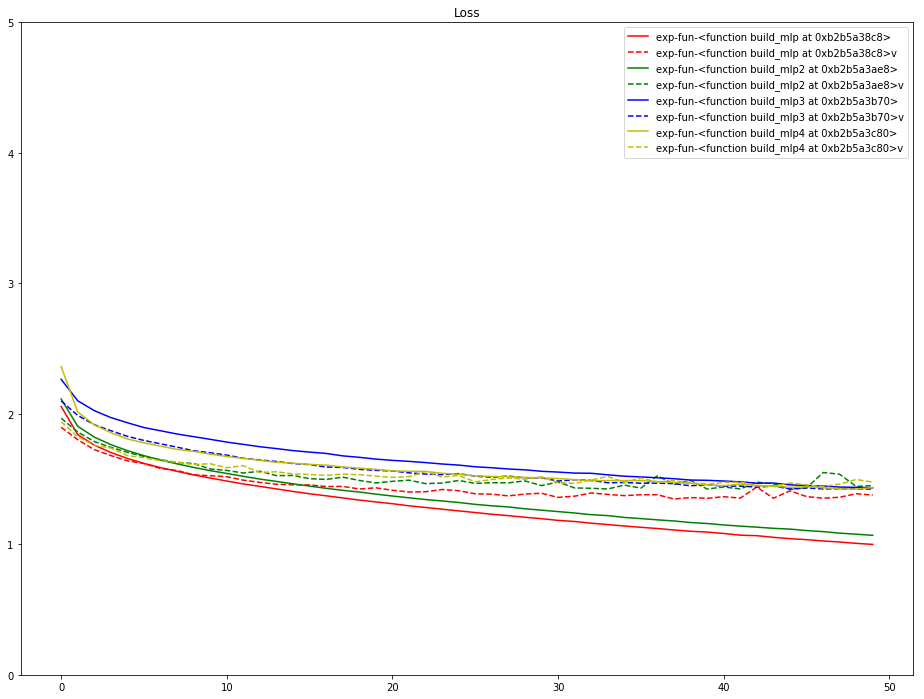

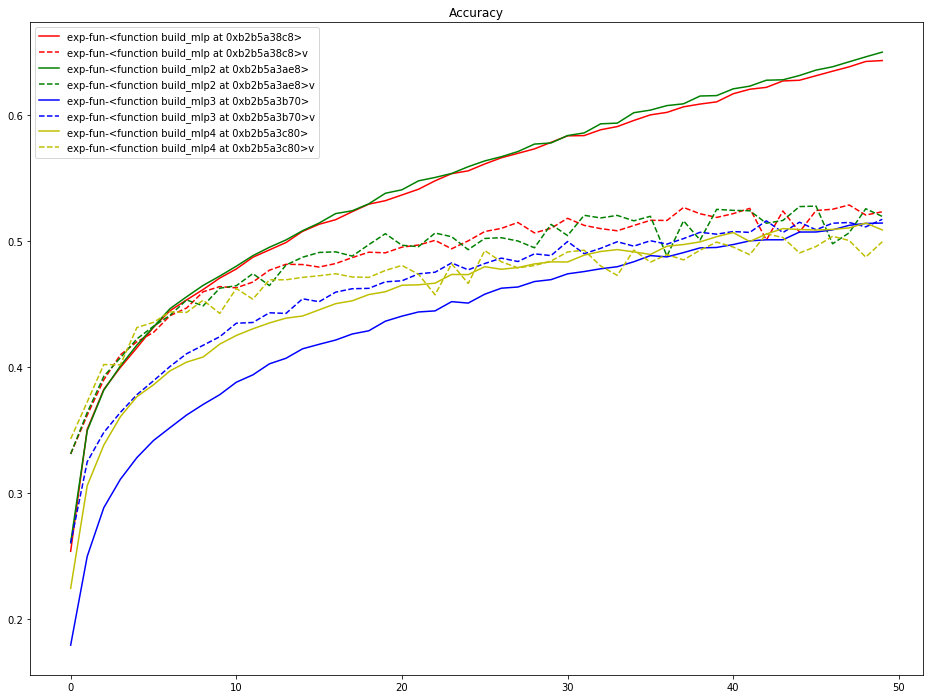

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond+'v', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond+'v', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()